In [1]:
import os
import sys
py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import itertools
import helper_functions as funcs
import instrument_matrices as matrices
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy_minimize_m3 as m3

# Setting Up Initial Instrument Parameters

In [2]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

theta_pol = -2.663
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 1 / 1.13  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163 # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load .csv files

In [3]:
csv_directory = '../../../data/unpolarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Plotting the Data in the HWP angle frame

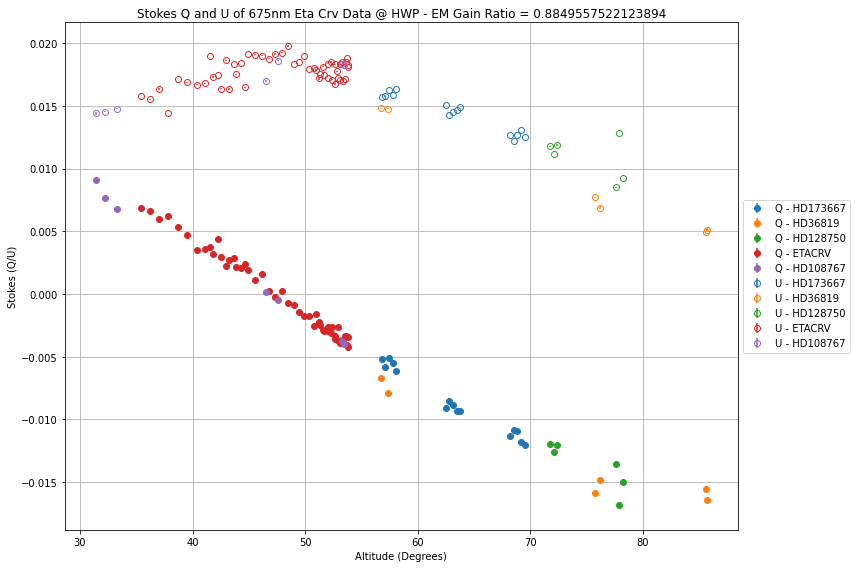

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate instrument matrix at HWP
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : ] / double_sum_matrix_at_HWP[0, 0])   

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            measurement_matrix[:, 0] = 1
            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix[:,:-1]) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix[:,:-1]) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Fitting for Matrix Inverted Values

Best Fit M3 Diattenuation: 0.017701052340468787
Best Fit Offset: -2.5206338879758183


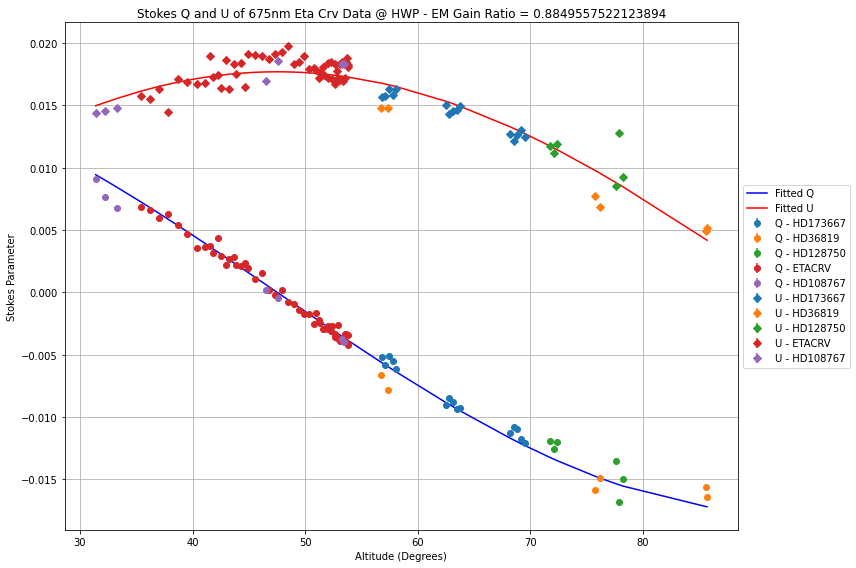

In [5]:
# Extract altitudes, Q_data, and U_data from the previous block of code
altitudes = [item[0] for item in Q_list]  # Extracting altitudes from Q_list (they are the same for U_list)
Q_data = np.array([item[1] for item in Q_list]).flatten()
U_data = np.array([item[1] for item in U_list]).flatten()

# Initial guesses for delta_m3, epsilon_m3, and offset
initial_guesses = [0, 0.01, 1]
bounds = [(0, 1), (-0.5, 0.5), (-10, 10)]

# Perform the minimization using Nelder-Mead with bounds
result = minimize(m3.residuals, initial_guesses, args=(altitudes, Q_data, U_data), method='Nelder-Mead', bounds=bounds)

# Extract the best-fit parameters
delta_m3_best, epsilon_m3_best, offset_best = result.x

print("Best Fit M3 Diattenuation: " + str(epsilon_m3_best))
print("Best Fit Offset: " + str(offset_best))

# Calculate the fitted Q and U values
Q_fitted, U_fitted = m3.propagate_unpol_source(delta_m3_best, epsilon_m3_best, offset_best, altitudes)
#Q_fitted, U_fitted = m3.propagate_unpol_source(0, 0.0176, -2.5, altitudes)

# Sort the fitted values by altitude
sorted_indices = np.argsort(altitudes)
altitudes_sorted = np.array(altitudes)[sorted_indices]
Q_fitted_sorted = Q_fitted[sorted_indices]
U_fitted_sorted = U_fitted[sorted_indices]

# Plotting the data and the fitted line
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='D', color=color, markerfacecolor=color, markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

# Plot the fitted line with different colors for Q and U
plt.plot(altitudes_sorted, Q_fitted_sorted, label='Fitted Q', linestyle='-', color='blue')
plt.plot(altitudes_sorted, U_fitted_sorted, label='Fitted U', linestyle='-', color='red')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Bootstrapping - Resampling Model Residuals

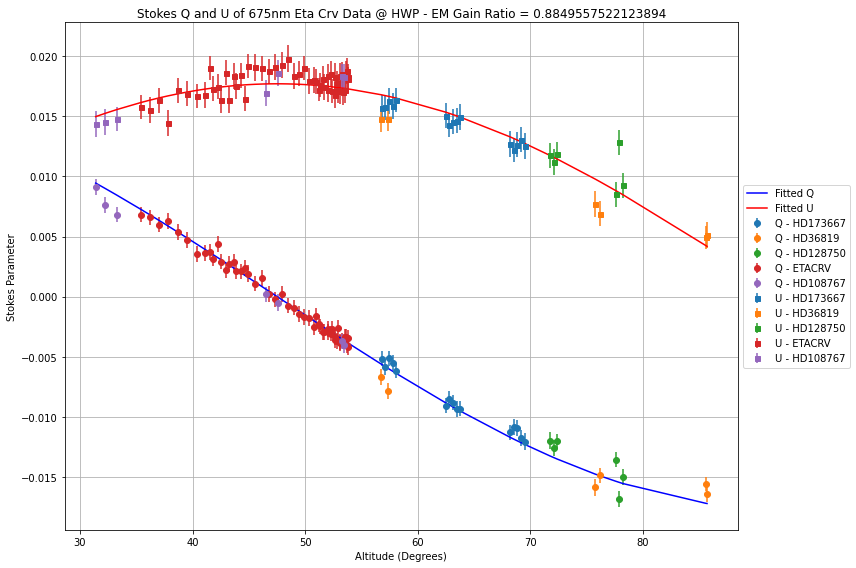

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import itertools

# Assuming 'all_data', 'fixed_params', 'matrices', and 'double_diff_factor' are already defined elsewhere in your code

# Extract altitudes, Q_data, and U_data from the previous block of code
altitudes = [item[0] for item in Q_list]  # Extracting altitudes from Q_list (they are the same for U_list)
Q_data = np.array([item[1] for item in Q_list]).flatten()
U_data = np.array([item[1] for item in U_list]).flatten()

# # Initial guesses for delta_m3, epsilon_m3, and offset
# initial_guesses = [0, 0.01, 1]
# bounds = [(0, 1), (-0.5, 0.5), (-10, 10)]

# # Perform the minimization using Nelder-Mead with bounds
# result = minimize(lambda params: np.sum(m3.residuals(params, altitudes, Q_data, U_data)**2), initial_guesses, bounds=bounds)

# # Extract the best-fit parameters
# delta_m3_best, epsilon_m3_best, offset_best = result.x

# print("Best Fit M3 Diattenuation: " + str(epsilon_m3_best))
# print("Best Fit Offset: " + str(offset_best))

# # Calculate the fitted Q and U values
# Q_fitted, U_fitted = m3.propagate_unpol_source(delta_m3_best, epsilon_m3_best, offset_best, altitudes)

# Calculate the residuals
Q_residuals = Q_data - Q_fitted
U_residuals = U_data - U_fitted

# Implement bootstrapping for error estimation
n_iterations = 1000
Q_bootstrap = np.zeros((n_iterations, len(Q_data)))
U_bootstrap = np.zeros((n_iterations, len(U_data)))

for i in range(n_iterations):
    sample_indices = np.random.choice(len(Q_data), len(Q_data), replace=True)
    Q_sample_residuals = Q_residuals[sample_indices]
    U_sample_residuals = U_residuals[sample_indices]
    Q_bootstrap[i, :] = Q_fitted + Q_sample_residuals
    U_bootstrap[i, :] = U_fitted + U_sample_residuals

# Calculate the standard deviation of the bootstrap samples
Q_err_bootstrap = np.std(Q_bootstrap, axis=0)
U_err_bootstrap = np.std(U_bootstrap, axis=0)

# Plotting the data and the fitted linea
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_bootstrap):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_bootstrap):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='s', color=color, markerfacecolor=color, markeredgecolor=color, markersize=5)
    plotted_labels.add(f'U - {obj}')

# Plot the fitted line with different colors for Q and U
plt.plot(altitudes_sorted, Q_fitted_sorted, label='Fitted Q', linestyle='-', color='blue')
plt.plot(altitudes_sorted, U_fitted_sorted, label='Fitted U', linestyle='-', color='red')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Bootstraping - Resampling Matrix Inverted Values

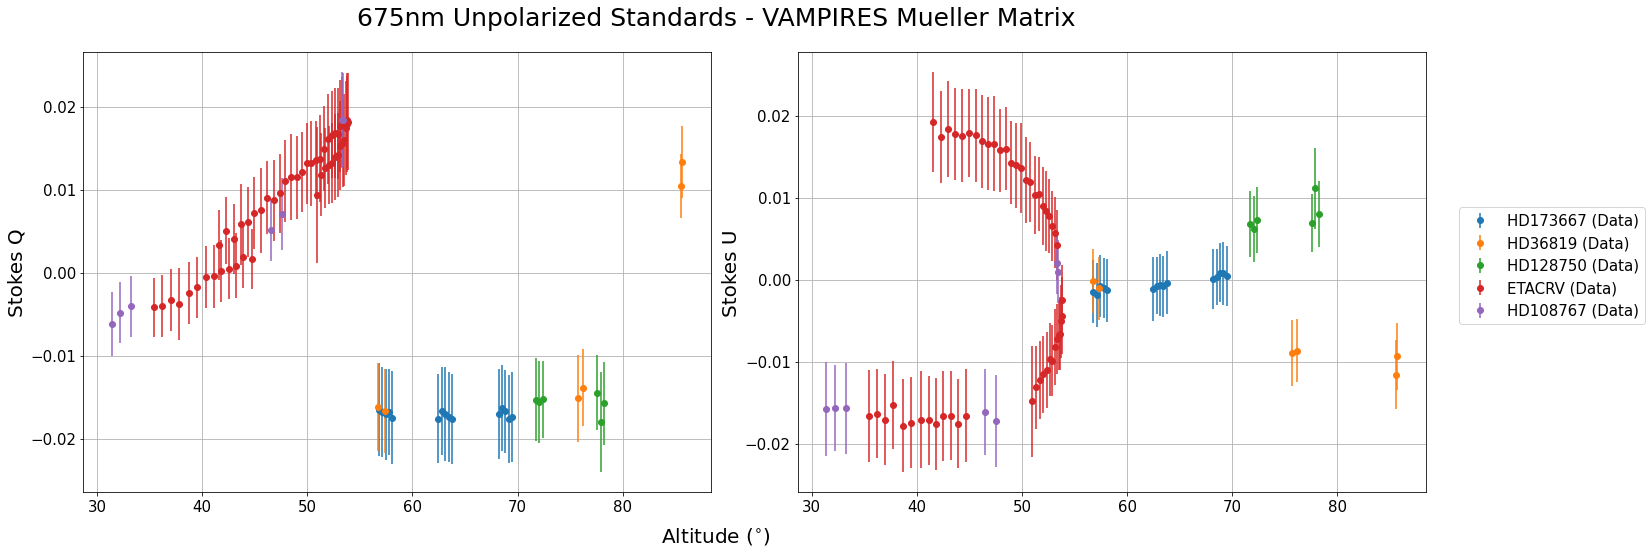


Target: HD173667
Altitude: 56.80 | Measured Q: -0.02
Altitude: 57.13 | Measured Q: -0.02
Altitude: 57.45 | Measured Q: -0.02
Altitude: 57.77 | Measured Q: -0.02
Altitude: 58.09 | Measured Q: -0.02
Altitude: 62.48 | Measured Q: -0.02
Altitude: 62.80 | Measured Q: -0.02
Altitude: 63.13 | Measured Q: -0.02
Altitude: 63.45 | Measured Q: -0.02
Altitude: 63.77 | Measured Q: -0.02
Altitude: 68.19 | Measured Q: -0.02
Altitude: 68.51 | Measured Q: -0.02
Altitude: 68.84 | Measured Q: -0.02
Altitude: 69.16 | Measured Q: -0.02
Altitude: 69.48 | Measured Q: -0.02
Altitude: 56.80 | Measured U: -0.00
Altitude: 57.13 | Measured U: -0.00
Altitude: 57.45 | Measured U: -0.00
Altitude: 57.77 | Measured U: -0.00
Altitude: 58.09 | Measured U: -0.00
Altitude: 62.48 | Measured U: -0.00
Altitude: 62.80 | Measured U: -0.00
Altitude: 63.13 | Measured U: -0.00
Altitude: 63.45 | Measured U: -0.00
Altitude: 63.77 | Measured U: -0.00
Altitude: 68.19 | Measured U: 0.00
Altitude: 68.51 | Measured U: 0.00
Altitude: 68

/home/rebeccaz/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rebeccaz/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rebeccaz/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rebeccaz/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rebeccaz/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_data, fixed_params, matrices, double_diff_factor, and funcs are already loaded

# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []
these_inst_matrices = []

model = matrices.full_system_mueller_matrix

# Parameters for bootstrapping
num_bootstrap_samples = 1000

# Function to calculate Q and U errors using bootstrapping
def calculate_stokes_errors(measurement_matrix, measurements, num_bootstrap_samples):
    bootstrap_samples = np.zeros((num_bootstrap_samples, 3))  # For dHWP, Q, U
    
    for i in range(num_bootstrap_samples):
        indices = np.random.choice(range(measurements.shape[0]), size=measurements.shape[0], replace=True)
        bootstrap_measurements = measurements[indices]
        bootstrap_matrix = measurement_matrix[indices]
        
        # Compute the Stokes parameters for the bootstrapped dataset
        s_HWP_bootstrap = np.linalg.pinv(bootstrap_matrix[:, :-1]) @ bootstrap_measurements
        bootstrap_samples[i] = s_HWP_bootstrap.flatten()
    
    s_HWP_std = bootstrap_samples.std(axis=0)
    
    return s_HWP_std, bootstrap_samples

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        parang = row["PA"]
        altitude = row["ALTITUDE"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate full instrument matrices for on-sky
            these_inst_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor=double_diff_factor)
            double_diff_matrix = these_inst_matrices[0]
            double_sum_matrix = these_inst_matrices[1]

            # Saving instrument matrices
            inst_matrices.append(double_diff_matrix)
            inst_matrices.append(double_sum_matrix)

            # Normalizing by the flux in the double sum matrix (?)
            first_rows.append(double_diff_matrix[0, : ] / double_sum_matrix[0, 0])

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector on-sky
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Setting the I component to be 1
            measurement_matrix[:, 0] = 1

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix[:, :-1]) @ measurements

            # Compute the errors for the Stokes parameters using bootstrapping
            s_HWP_std, bootstrap_samples = calculate_stokes_errors(measurement_matrix, measurements, num_bootstrap_samples)

            # Extract Q and U from s_HWP and their errors
            dHWP = s_HWP[0, 0]
            Q = s_HWP[1, 0]
            U = s_HWP[2, 0]
            Q_err = s_HWP_std[1]
            U_err = s_HWP_std[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Creating the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plotting Stokes Q
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'{obj} (Data)' if f'{obj} (Data)' not in plotted_labels else None
    ax1.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'{obj} (Data)')

ax1.set_ylabel("Stokes Q", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(True)

# Plotting Stokes U
plotted_labels = set()
for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'{obj} (Data)' if f'{obj} (Data)' not in plotted_labels else None
    ax2.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color)
    plotted_labels.add(f'{obj} (Data)')

ax2.set_ylabel("Stokes U", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True)

# Creating a single legend for both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=15, bbox_to_anchor=(1.15, 0.5))

# Adding a single title and x-axis label for both plots
fig.suptitle(f"675nm Unpolarized Standards - VAMPIRES Mueller Matrix", fontsize=25, y=0.95)
fig.text(0.5, 0.02, 'Altitude ($^{\circ}$)', ha='center', fontsize=20)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to fit title and x-axis label
plt.gcf().set_facecolor('white')
plt.show()

# Print the values and residuals
Q_residuals = []
U_residuals = []

for obj in unique_objects:
    print(f"\nTarget: {obj}")
    obj_Q_list = [(alt, Q) for alt, Q, _, o in Q_list if o == obj]
    obj_U_list = [(alt, U) for alt, U, _, o in U_list if o == obj]

    for (altitude, Q) in obj_Q_list:
        print(f"Altitude: {altitude:.2f} | Measured Q: {Q:.2f}")

    for (altitude, U) in obj_U_list:
        print(f"Altitude: {altitude:.2f} | Measured U: {U:.2f}")

# Calculate and print statistics for the residuals
Q_residuals = np.array(Q_residuals)
U_residuals = np.array(U_residuals)

# Taking the absolute value of the residuals
Q_residuals = np.abs(Q_residuals)
U_residuals = np.abs(U_residuals)

print("\nStatistics for Stokes Q Residuals:")
print(f"Median: {np.median(Q_residuals):.2f}")
print(f"Mean: {np.mean(Q_residuals):.2f}")
print(f"Standard Deviation: {np.std(Q_residuals):.2f}")

print("\nStatistics for Stokes U Residuals:")
print(f"Median: {np.median(U_residuals):.2f}")
print(f"Mean: {np.mean(U_residuals):.2f}")
print(f"Standard Deviation: {np.std(U_residuals):.2f}")
